In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [4]:
# Load the metadata
metadata_path = "/Users/stageacomeback/Desktop/HAM10000/data/HAM10000/HAM10000_metadata.csv"  # Path to the metadata CSV
metadata = pd.read_csv(metadata_path)
metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [5]:
# Dataset path (folder containing images)
image_folder = "/Users/stageacomeback/Desktop/HAM10000/data/all_images"  # Replace with the actual path to the images

In [6]:
# Labels and their meanings
lesion_labels = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
# Add a column for the full path to images
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(image_folder, x + '.jpg'))

In [8]:
# Filter rows for which images are missing
metadata = metadata[metadata['image_path'].apply(os.path.exists)]

# Encode the target labels
encoder = LabelEncoder()
metadata['label'] = encoder.fit_transform(metadata['dx'])

# Convert labels to one-hot encoding
labels = to_categorical(metadata['label'], num_classes=len(lesion_labels))

# Load images and preprocess
IMG_SIZE = 128  # Resize images to 128x128
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    return img

In [9]:
images = np.array([preprocess_image(img_path) for img_path in metadata['image_path']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=metadata['label'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
datagen.fit(X_train)

In [11]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(lesion_labels), activation='softmax')
])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 85s 332ms/step - accuracy: 0.4899 - loss: 1.6301 - val_accuracy: 0.2421 - val_loss: 2.2700 - learning_rate: 0.0010
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 317ms/step - accuracy: 0.6394 - loss: 1.0423 - val_accuracy: 0.6530 - val_loss: 0.9745 - learning_rate: 0.0010
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 312ms/step - accuracy: 0.6819 - loss: 0.8905 - val_accuracy: 0.6975 - val_loss: 0.8152 - learning_rate: 0.0010
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - accuracy: 0.6950 - loss: 0.8429 - val_accuracy: 0.7179 - val_loss: 0.7735 - learning_rate: 0.0010
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 312ms/step - accuracy: 0.7056 - loss: 0.8082 - val_accuracy: 0.6850 - val_loss: 1.0671 - learning_rate: 0.0010
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 311ms/step - accuracy: 0.7093 - loss: 0.7878 - val_accuracy: 0.6790 - val_loss: 1.1775 - learning_rate: 0.0010
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 311ms/step - accuracy: 0.7153 - loss:

In [13]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7763 - loss: 0.6098
Test Accuracy: 77.63%


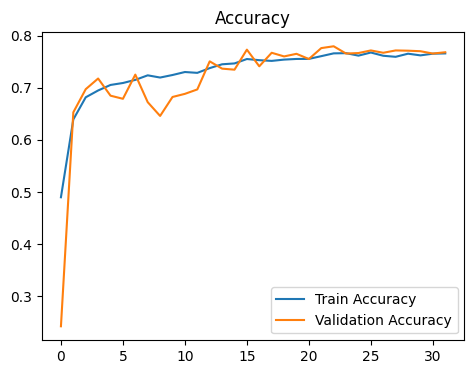

In [14]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

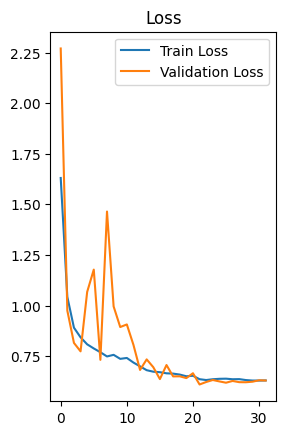

In [17]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()